In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import graph_generator as gg
import graph_visualiser as gv
import importlib

In [85]:
importlib.reload(gg)
importlib.reload(gv)

<module 'graph_visualiser' from '/home/michal/PycharmProjects/algorithms/MOWNiT/lab2/graph_visualiser.py'>

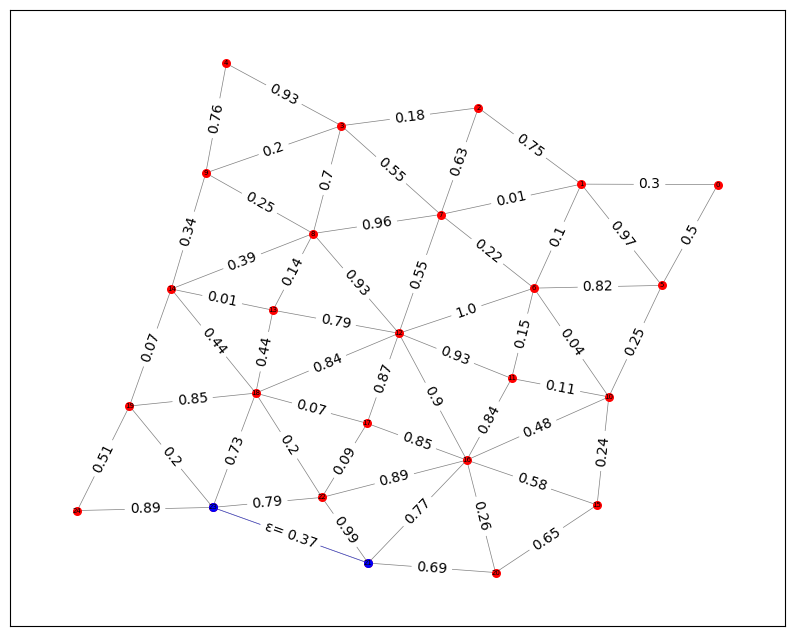

In [98]:
G, source, target, E = gg.generate_triangulation(5, 5)
gv.draw_with_resistance(G, source, target, small=True)

In [100]:
def kirchoff(g, s, t):
    def add_sum_component(v1, v2):
        edge = g[v1][v2]['edge']
        if edge.voltage > 0:
            if v1 < v2:
                B[eq_no] -= edge.voltage
            else:
                B[eq_no] += edge.voltage
        else:
            if v1 < v2:
                A[eq_no][edge.index] += edge.resistance
            else:
                A[eq_no][edge.index] -= edge.resistance

    n = g.number_of_nodes()
    m = g.number_of_edges()

    cycle_basis = nx.cycle_basis(g)
    no_of_eq = n + len(cycle_basis)
    A = np.zeros((no_of_eq, m))
    B = np.zeros(no_of_eq)

    eq_no = 0
    for cycle in cycle_basis:
        for i in range(1, len(cycle)):
            add_sum_component(cycle[i-1], cycle[i])
        add_sum_component(cycle[-1], cycle[0])
        eq_no += 1

    for v in range(n):
        for neighbor in g.neighbors(v):
            edge = g[v][neighbor]['edge']
            if v < neighbor:
                A[eq_no][edge.index] += 1
            else:
                A[eq_no][edge.index] -= 1
        eq_no += 1
    transposed = A.T
    ans = np.linalg.solve(np.matmul(transposed, A), np.matmul(transposed, B))
    for a, b in g.edges:
        edge = g[a][b]['edge']
        edge.current = ans[edge.index]

    for v in range(n):
        suma = 0
        for neighbor in g.neighbors(v):
            if v < neighbor:
                suma += g[v][neighbor]['edge'].current
            else:
                suma -= g[v][neighbor]['edge'].current
        print(f"{v} : {suma}")


In [101]:
kirchoff(G, source, target)

0 : 4.336808689942018e-17
1 : 4.163336342344337e-17
2 : 3.122502256758253e-17
3 : 3.8163916471489756e-17
4 : 6.591949208711867e-17
5 : 5.551115123125783e-17
6 : 6.591949208711867e-17
7 : 1.734723475976807e-17
8 : -9.71445146547012e-17
9 : 6.938893903907228e-17
10 : 5.551115123125783e-17
11 : 5.551115123125783e-17
12 : 1.3877787807814457e-17
13 : -1.5265566588595902e-16
14 : -5.551115123125783e-17
15 : 1.5265566588595902e-16
16 : 0.0
17 : -5.551115123125783e-17
18 : 2.7755575615628914e-17
19 : -2.0816681711721685e-16
20 : -6.938893903907228e-17
21 : 1.1102230246251565e-16
22 : -6.938893903907228e-17
23 : 0.0
24 : 2.7755575615628914e-17


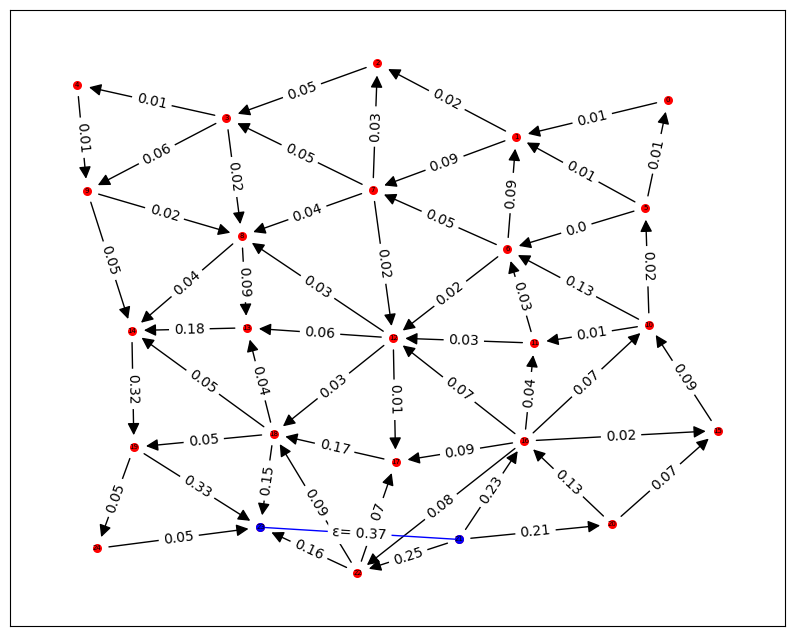

In [102]:
gv.draw_with_current(G, source, target, small=True)

In [103]:
def nodal_potentials(g, s, t):
    n = g.number_of_nodes()
    A = np.zeros((n, n))
    B = np.zeros(n)
    A[s][s] = 1
    B[s] = g[s][t]['edge'].voltage
    A[t][t] = 1
    B[t] = 0

    for v in range(n):
        if v != s and v != t:
            for neighbor in g.neighbors(v):
                edge = g[v][neighbor]['edge']
                A[v][v] += 1/edge.resistance
                A[v][neighbor] -= 1/edge.resistance

    potentials = np.linalg.solve(A, B)
    for a, b in g.edges:
        edge = g[a][b]['edge']
        if a < b:
            edge.current = (potentials[a] - potentials[b]) / edge.resistance
        else:
            edge.current = (potentials[b] - potentials[a]) / edge.resistance


In [104]:
nodal_potentials(G, source, target)

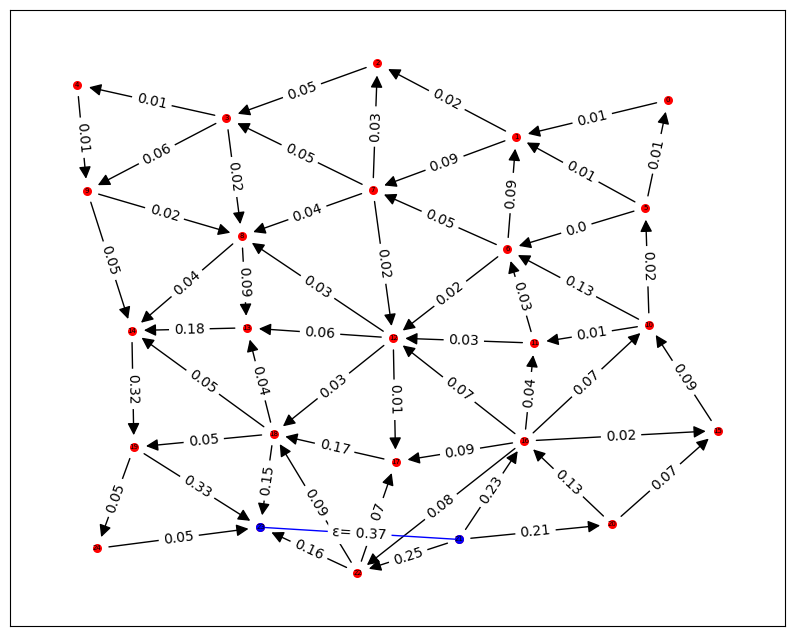

In [105]:
gv.draw_with_current(G, source, target)